# CS 594 / CS 690 - Assignment 06
### October 8, 2018
---

For this assignment, you must work in groups of one or two students. Each person is responsible to write their own code, but the group will (together) discuss their solution.  In this notebook, we provide you with basic functions for completing the assignment.  *Complete the assignment in this notebook.  You will need to modify existing code and write new code to find a solution*.  Each member of the group must upload their own work (i.e., a notebook file) to GitHub.

*Note: Running a cell will not rerun previous cells.  If you edit code in previous cells, you must rerun those cells.  We recommend using* `Run All` *to avoid any errors results from not rerunning previous cells.  You can find this in the menu above:* `Cell -> Run All`

During today's lecture, we learned about $k$-means clusterings. In the previous assignment, we learned to use PySpark's parallel versions of the `map` and `reduce` functions. In this assignment, we will be implementing the $k$-means algorithm in parallel with PySpark.

### Import PySpark
Run the cell below to verify that Java, Spark, and PySpark are successfully installed. The cell generates a dataset of numbers (i.e., 1, 2, 3, 4, 5, 6, 7, 8, 9, and 10) and computes their sum. The expected output is 45. If you run into an error, return to the Spark-Install scripts from before.

In [1]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
data = sc.parallelize(range(1,10))
print(data.reduce(lambda x,y: x+y))
sc.stop()

45


### Problem 1:
**Implement $k$-means in spark.**

Below we have provided you with several helper functions that can be used to implement $k$-means.

In [2]:
import numpy as np

# Add value1 and value 2
# Useful as a reduce function
def addValues(val1, val2):
    return val1 + val2

# Calculate the euclidian distance between two 2D points
# HINT: ref 1
# Input: point_a: np.array(x,y)
#        point_b: np.array(x,y)
# Return: distance
def dist(point_a, point_b):
    return np.sqrt(np.sum((point_a - point_b)**2))

# Find the centroid that the `point` is closest to and return the centroid's ID
# The centroid ID in this case is simply its index in the `centroids` list
# Input: point: np.array(x,y)
#        centroids: [np.array(x1,y1), np.array(x2,y2), ..., np.array(xK,yK)], 
#                   where K is the number of clusters
# Return: clusterID
def getClosestCentroidID(point, centroids):
    distances = [dist(point, centroid) for centroid in centroids]
    return np.argmin(distances)

# Convert the given `line` to a point
# As in assignment 4, we recommend using numpy arrays to store the (x,y)-coordinates of the points
# Input: line: "float float"
# Return: point: np.array(x,y)
def lineToPoint(line):
    return np.array([float(x) for x in line.split()])

# Given a point (i.e., (x,y) and a list of centroids (i.e., list of points),
# find the closest centroid and assign that cluster to the point
# Input: points_rdd: <<np.array(x1,y1), np.array(x2,y2), ... np.array(xN,yN)>>,
#                    where N is the number of lines in the file
#        centroids:  [np.array(x1,y1), np.array(x2,y2), ..., np.array(xK,yK)],
#                    where K is the number of clusters
# Return: RDD of clustered points: <<(clusterID, np.array(x1, y1)), (clusterID, np.array(x2, y2)), ...>>
def assignPointsToClosestCluster(points_rdd, centroids):
    return points_rdd.map(lambda x: (getClosestCentroidID(x, centroids), x))
    
# Read in the file and convert each line into a point (using `lineToPoint`) with Spark
# Return: RDD of points: <<np.array(x1,y1), np.array(x2,y2), ... np.array(xN,yN)>>,
#                        where N is the number of lines in the file
def readPointsFromFile(filename):
    sc = SparkContext.getOrCreate()
    lines = sc.textFile (filename)
    points = lines.map(lineToPoint)
    return points

# Sum the distance that each centroid moved by
# Input: old_centroids: [np.array(x1,y1), np.array(x2,y2), ..., np.array(xK,yK)],
#                       where K is the number of clusters
#        new_centroids: [np.array(x1,y1), np.array(x2,y2), ..., np.array(xK,yK)],
#                       where K is the number of clusters
# Return: sum of distances
def calculateChangeInCentroids(old_centroids, new_centroids):
    return sum([dist(old, new) for old, new in zip(old_centroids, new_centroids)])

#### References
- [1: euclidian distance for two dimensions](https://en.wikipedia.org/wiki/Euclidean_distance#Two_dimensions)

----

In the next cell, you will implement the key components of the $k$-means clustering algorithm.  The first piece of the algorithm is calculating the mean coordinates of each cluster. In plain terms, to calculate the mean (i.e., average) $x$-coordinate of Cluster $j$, you must first find all of the points in the cluster. Then you must sum their $x$-coordinate values.  Finally, you divide that sum by the number of points in the cluster.  This produces the mean $x$-coordinate.  You must repeat this process for the $y$-coordinate (or for greater efficiency, you can perform it in parallel with the $x$-coordinate calculation). The equation below demonstrates how to calculate the mean coordinates of a given cluster:

$$\overline{Cluster_j} = \left\langle \frac{x_1 + x_2 + \ldots + x_n}{n} , \frac{y_1 + y_2 + \ldots + y_n}{n} \right\rangle$$ where $$n = \left\vert Cluster_j \right\vert$$ and $$\langle x_1, y_1\rangle, \langle x_2, y_2\rangle, \ldots, \langle x_n, y_n\rangle \in Cluster_j$$

Your task is to **implement the `calculateClusterMeans` function and then test it against our provided test case**.  You will need to calculate the expected output by hand to ensure that your function produces the correct result.

In [3]:
# Calculate the mean coordinates of each cluster.
# Input: clustered_points_rdd: <<clustered_point1, clustered_point2, ..., clustered_pointN>>,
#                              where N is the number of clustered_points, and
#                              where each clustered_point looks like (clusterID, np.array(x,y))
# Return: [centroid1, centroid2, ..., centroidK],
#         where K is the number of clusters, and
#         where each centroid is np.array(x,y)
def calculateClusterMeans(clustered_points_rdd):
    # Sum the xs and ys of all points in each cluster
    # HINT: ref 1
    cluster_sums = clustered_points_rdd.reduceByKey(addValues)
    
    # Count the number of points in each cluster
    # HINT: ref 2
    cluster_counts = sc.parallelize(clustered_points_rdd.countByKey().items())

    # Divide the x,y sums for each cluster by the number of points in each cluster
#    cluster_means = []
    cluster_mean_tuples = sorted(cluster_sums.join(cluster_counts).mapValues(lambda x: x[0]/x[1]).collect(), key=lambda x: x[0])
    cluster_means = [x[1] for x in cluster_mean_tuples]
    return cluster_means

sc = SparkContext.getOrCreate()
test_clustered_points = sc.parallelize([(0, np.array([1.0, 2.0])),
                                        (0, np.array([0.5, 1.0])),
                                        (1, np.array([4.0, 8.0])),
                                        (1, np.array([0.0, -1.0]))
                                       ])
print(calculateClusterMeans(test_clustered_points))
# Expected output: [np.array([0.75, 1.5]), np.array([2.0, 3.5])]


[array([0.75, 1.5 ]), array([2. , 3.5])]


#### References
- [1: reduceByKey](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey)
- [2: countByKey](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.countByKey)

----

You now have all the tools you need to write the main $k$-means function.  In this function, **your task is to read in the points from the provided file, cluster the points into $K$ clusters, and then return the clustering results (cluster centroids and clustered points)**.   Your code should accept two arguments: 1) the filename of the file containing the data that should be clustered and 2) the number of clusters to create. The input files we provide (`contig.txt` and `mickey.txt`) have one data point per line; the coordinates of the data points are two space delimited floating point numbers (i.e., $x$ and $y$). Your code should output the final centroids of each cluster as well as each point and its assigned cluster. Remember to use the functions that we have given you and that you have implemented in the previous cells (i.e., `readPointsFromFile`, `assignPointsToClosestCluster`, `calculateClusterMeans`, `assignPointsToClosestCluster`, and `calculateChangeInCentroids`.

We have provided you with a very small, simple dataset to test against (i.e., `simple.txt`). This dataset is small enough that it can be printed out in its entirety.  It contains two very distinct clusters.  

In [6]:
import math

# Cluster the points in the file into K clusters using k-means clustering
# Input: filename: file that contains the points (one per line)
#        K: number of clusters
# Return: [centroid1, centroid2, ..., centroidK] and [clustered_point1, clustered_point2, ..., clustered_pointN]
#         where K is the number of clusters,
#         where N is the number of points,
#         where centroid is np.array(x,y), and
#         where each clustered_point is (clusterID, np.array(x,y))
def clusterFile(filename, K):
    # Read in the file and convert to points
    points = readPointsFromFile(filename)
    
    # Randomly choose K points as the centroids
    # HINT: ref 1
    centroids = points.takeSample(False, K)

    # Assign each point to the centroid closest to it
    clustered_points = assignPointsToClosestCluster(points, centroids)
    
    # Begin the iterative portion of k-means,
    # continue until the changes in centroids are very small (e.g., < .0001)
    change_in_centroids = math.inf
#    iter = 0
#    max_iter = 100
    while change_in_centroids > 0.0001:
        old_centroids = centroids
        # Calculate the new centroids based on the means of the current clusters
        centroids = calculateClusterMeans(clustered_points)
    
        # Assign the points to the new centroids
        clustered_points = assignPointsToClosestCluster(points, centroids)
    
        # Calculate the change in the centroids since the last iteration
        change_in_centroids = calculateChangeInCentroids(old_centroids, centroids)
#        iter += 1
#        if iter >= max_iter: break

    return centroids, clustered_points.collect()

centroids, clustered_points = clusterFile('simple.txt', 2)

print("Clustered Data")
prev_cluster_id = -1
for clustered_point in sorted(clustered_points, key=lambda x: x[0]):
    cluster_id, point_coords = clustered_point
    if cluster_id > prev_cluster_id:
        print("\tCluster {}:".format(cluster_id))
    prev_cluster_id = cluster_id
    print("\t\tCoordinates: {}".format(point_coords))

print("Cluster Centers")
for idx, centroid in enumerate(centroids):
    print("\tCluster {}: {}".format(idx, centroid))

Clustered Data
	Cluster 0:
		Coordinates: [-4.44375343  0.        ]
		Coordinates: [-4.42332439  0.        ]
		Coordinates: [-4.21117849  0.        ]
		Coordinates: [-4.19834549  0.        ]
		Coordinates: [-4.13252583  0.        ]
	Cluster 1:
		Coordinates: [3.38701979 0.        ]
		Coordinates: [3.56450093 0.        ]
		Coordinates: [3.67432789 0.        ]
		Coordinates: [3.76562207 0.        ]
		Coordinates: [3.88865504 0.        ]
		Coordinates: [4.20330179 0.        ]
Cluster Centers
	Cluster 0: [-4.28182553  0.        ]
	Cluster 1: [3.74723792 0.        ]


#### References
- [1: takeSample](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.takeSample)

----

In the cell below, **your task is to devise a way to visualize the clusters you have created** (to verify that the algorithm works as expected on larger datasets).  We have provided you with code that plots each point (using `matplotlib`), but you must extend the code to plot the cluster centers as well as color each point based on the cluster it is in.

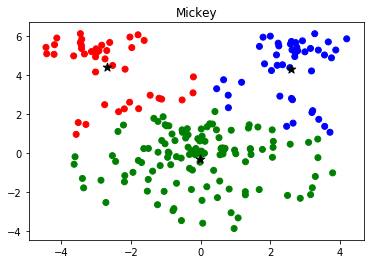

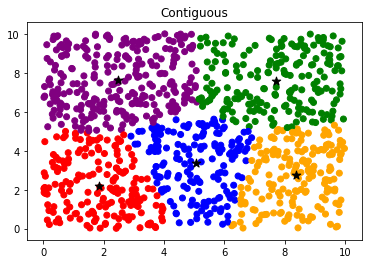

In [7]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# Plot the clustered points along with the cluster centers.
# The points should be colored based on the cluster they are in.
# Input: centroids: [(x1,y1), (x2,y2), ..., (xK,yK)], 
#                   where K is the number of clusters
#        clusteredPoints: [(clusterID, (x1,y1)), (clusterID, (x2,y2)), ... (clusterID, (xN,yN))], 
#                         where N is the number of points
def plotClusters(centroids, clustered_points, title=None):
    if len(clustered_points) <= 0:
        return
    
    # Extract the cluster ids and points from clusteredPoints
    # See ref 1
    cluster_ids, points = zip(*clustered_points)
    # Extract x and y values from the points and centroids
    point_xs, point_ys = zip(*points)
    centroid_xs, centroid_ys = zip(*centroids)
    
    fig = plt.figure()
    
    # Plot each cluster center as a black star (that is slightly larger
    #      than the data points plotted below)
    # HINT: ref 4  (specifically look at the 'marker', 's', and 'c' keyword args)
    plt.scatter(centroid_xs, centroid_ys, marker="*", s=80, c="black")
    
    # Pick a color to use for each cluster (e.g., cluster1 is "blue", cluster2 is "red", ...)
    # HINT: ref 2, ref 3
    colors = ["red", "green", "blue", "orange", "purple"]
    
    # Plot each point in the figure using a scatter plot
    # Each point should be colored based on the cluster that it is in
    # HINT: ref 4 (specifically look at the 'marker', 'c', 'cmap', and 'norm' keyword args)
    # The 'zorder' keyword argument is used here to make sure the points are drawn behind
    #      the cluster center stars
    plt.scatter(point_xs, point_ys, marker='o', zorder=-1, c=[colors[i] for i in cluster_ids])

    if title:
        plt.title(title)
    plt.show()

centroids, clustered_points = clusterFile('mickey.txt', 3)
plotClusters(centroids, clustered_points, title="Mickey")
centroids, clustered_points = clusterFile('contig.txt', 5)
plotClusters(centroids, clustered_points, title="Contiguous")

#### References
- [1: zip(*)](https://stackoverflow.com/a/5917600)
- [2: using normalization and colormaps in matplotlib](https://stackoverflow.com/questions/43132300/how-can-i-normalize-colormap-in-matplotlib-scatter-plot)
- [3: colormap reference](https://matplotlib.org/examples/color/colormaps_reference.html)
- [4: scatter](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html?highlight=matplotlib%20pyplot%20scatter#matplotlib.pyplot.scatter)

### Things to Consider:
* How do you choose $K$ for your dataset?
  * A popular technique is the elbow method:
    * https://pythonprogramminglanguage.com/kmeans-elbow-method/
    * https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method
* Do you always get the same results from $k$-means?  Is it non-determinisitc?  Is this an error in your code or a feature of the algorithm?
* How would you optimize the code to work for larger datasets (e.g., 100GBs of points)?
* How would you generalize the code to work for larger-dimensionality datasets?

### Project Questions:
**Answer the following questions, in a couple sentences each, in the cells provided below**
* Do you work alone or in team? If in team, indicate who is your collaborator and what are the skills / expertise he/she is bringing to the project
* What is the dataset you are considering? 
* What are the possible key question(s) you want to answer? Are the questions too general? Are the questions too narrow?


I will be working alone.

I am currently considering the Sentiment 140 Data set (<https://www.kaggle.com/kazanova/sentiment140>). This data contains 1.6 million tweets that are tagged with a sentiment score. There are many prepared twitter data sets available, and I may consider others if this one is not suitable for whatever reason.

I plan to do topic modeling. What are the key topics that appear in the tweets? How do tweets cluster based on these topics? Which topics are the most prevalent? Do topics relate to one another in any way; i.e., do tweets about one topic also tend to be about another topic? Since we have sentiment information as well, do tweets in the same topic cluster tend to have the same sentiment? Is there any dependence between topic and sentiment? Since we have time information, how do the key topics evolve with time?

### Assignment Questions:
**Answer the following questions, in a couple sentences each, in the cells provided below**
* List the key tasks you accomplished during this assignment?
* Describe the challenges you faced in addressing these tasks and how you overcame these challenges?
* Did you work with other students on this assignment? If yes, how did you help them? How did they help you? Be as specific as possible.


I implemented the K-means clustering algorithm in Spark. I applied it to simple 2D data sets. I used matplotlib to visualize the clusters and their centroids.

I had to use the references to look up the usage of some functions.

I worked with no one on the assignment.